# Testing BIBIMBpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcols
import scipy.stats

In [2]:
import pandas

In [3]:
import agama

agama.setUnits(mass = 1, length = 1, velocity = 1)

In [4]:
import bibimbpy

## Create initial conditions

In [5]:
r_ic = 4
phi_ic = 0
z_ic = 0
vz_ic = 0

vr_ic = np.linspace(-200,200,200)
vphi_ic = -np.linspace(-400,0,200)

In [8]:
ic,axis = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [9]:
ic.shape

(40000, 6)

In [10]:
axis

[array([-200., -200., -200., ...,  200.,  200.,  200.]),
 array([400.        , 397.98994975, 395.9798995 , ...,   4.0201005 ,
          2.01005025,  -0.        ])]

## Generate axisymmetric potential

In [11]:
## McMillan17 Potential
#best-fit potential from McMillan(2017)
#Units: 1 Msun, 1 Kpc, 1 km/s

#[Potential thin disk]
thindisc = {"type": "Disk",
"surfaceDensity": 8.95679e+08,
"scaleRadius": 2.49955,
"scaleHeight": 0.3}

#[Potential thick disk]
thickdisc = {"type": "Disk",
"surfaceDensity": 1.83444e+08,
"scaleRadius": 3.02134,
"scaleHeight": 0.9}

#[Potential HI gas disk]
HIgas = {"type": "Disk",
"surfaceDensity": 5.31319e+07,
"scaleRadius": 7,
"scaleHeight": -0.085,
"innerCutoffRadius": 4}

#[Potential molecular gas disk]
molgas = {"type": "Disk",
"surfaceDensity": 2.17995e+09,
"scaleRadius": 1.5,
"scaleHeight": -0.045,
"innerCutoffRadius": 12}

#[Potential bulge]
bulge = {"type": "Spheroid",
"densityNorm": 9.8351e+10,
"axisRatioZ": 0.5,
"gamma": 0,
"beta": 1.8,
"scaleRadius": 0.075,
"outerCutoffRadius": 2.1}

#[Potential halo]
halo = {"type": "Spheroid",
"densityNorm": 8.53702e+06,
"axisRatioZ": 1,
"gamma": 1,
"beta": 3,
"scaleRadius": 19.5725}

In [12]:
potthin = agama.Potential(**thindisc)
potthick = agama.Potential(**thickdisc)
potHI = agama.Potential(**HIgas)
potmol = agama.Potential(**molgas)
potbulge = agama.Potential(**bulge)
pothalo = agama.Potential(**halo)

In [13]:
pbase = agama.Potential(potthin,potthick,potHI,potmol,potbulge,pothalo)



## Generate perturbation and its m=0 mode

### generate scaling file

In [14]:
bibimbpy.utils.generate_scaling_file(1,"dehnen",100,"test_scaling_file.txt")

In [15]:
pert_params_dict = {"type":"Ferrers","mass":1e10,"scaleRadius":5,"axisRatioY":0.8,"axisRatioZ":0.2,
                   "scale":"test_scaling_file.txt"}


In [16]:
pot_pertuber = agama.Potential(**pert_params_dict)

scaling_file = pert_params_dict["scale"]

#make the static part
pert_params_dict.pop("scale")
pot_pertuber_static = agama.Potential(**pert_params_dict)
pot_pertuber_m0_static = agama.Potential(type='CylSpline', potential=pot_pertuber_static, 
                                         mmax=0, rmin=0, rmax=20)
pot_pertuber_m0 = agama.Potential(type='CylSpline', potential=pot_pertuber_static, mmax=0, rmin=0, rmax=20, 
                                    scale=bibimbpy.utils.invert_scaling_file(scaling_file))

In [17]:
pbase_m0 = agama.Potential(pbase,pot_pertuber_m0_static)

In [20]:
r_ = np.linspace(0.1,15,100)
phi_ = np.linspace(0,2*np.pi,100)

R,PHI = np.meshgrid(r_,phi_)

r = R.flatten()
phi = PHI.flatten()

z = np.zeros_like(r)
points = np.column_stack((r*np.cos(phi),r*np.sin(phi),z))
points_line = np.column_stack((r_,r_*0,r_*0))

In [21]:
pm0_stat_eval = pot_pertuber_m0_static.potential(points)

pm0_stat_force = pot_pertuber_m0_static.force(points_line)
pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)

pm0_stat_base_force = pbase_m0.force(points_line)
pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)

In [22]:
t0 = 10

In [23]:
pm0_eval = pot_pertuber_m0.potential(points,t=t0)

pm0_force = pot_pertuber_m0.force(points_line,t=t0)
pm0_omega = np.sqrt(-pm0_force[:,0]/r_)

In [24]:
ppert_eval = pot_pertuber.potential(points,t=t0)

ppert_force = pot_pertuber.force(points_line,t=t0)
ppert_omega = np.sqrt(-ppert_force[:,0]/r_)

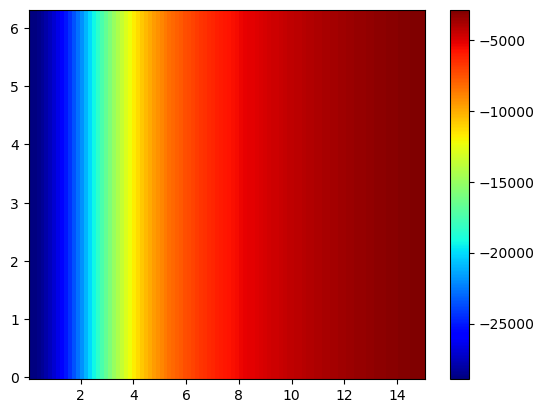

In [25]:
plt.pcolormesh(R,PHI,pm0_stat_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

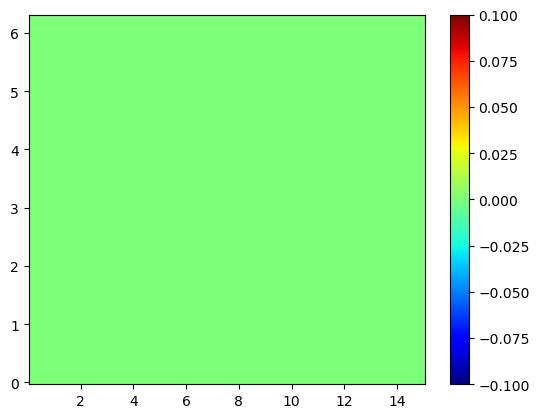

In [26]:
plt.pcolormesh(R,PHI,pm0_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

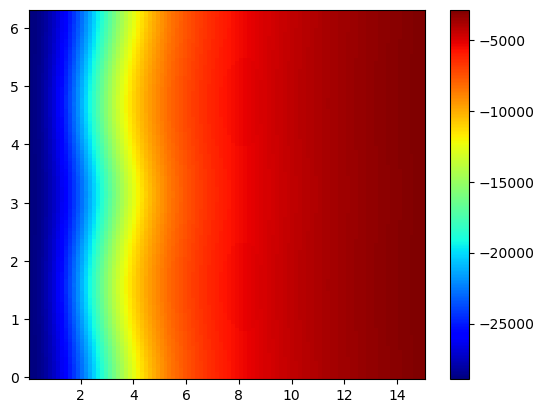

In [27]:
plt.pcolormesh(R,PHI,ppert_eval.reshape(R.shape),cmap="jet")
plt.colorbar()

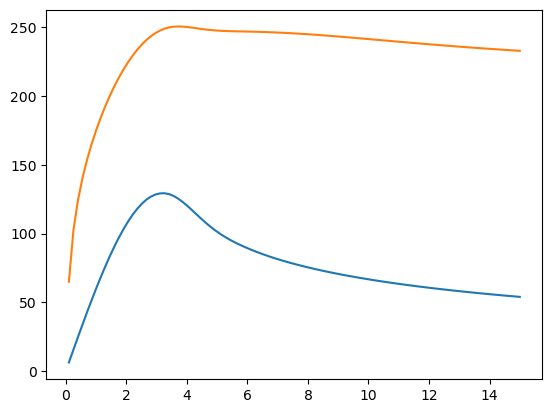

In [28]:
plt.plot(r_,r_*pm0_stat_omega)
plt.plot(r_,r_*pm0_stat_base_omega)

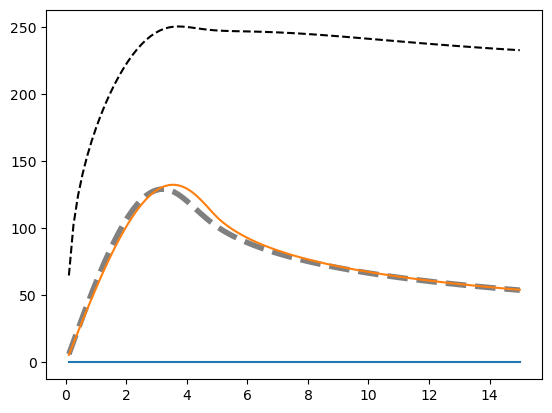

In [29]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*pm0_stat_omega,ls="--",color="grey",lw=4)
plt.plot(r_,r_*pm0_omega)
plt.plot(r_,r_*ppert_omega)

In [30]:
p_timedep = agama.Potential(pbase,pot_pertuber_m0,pot_pertuber)

In [31]:
t = 10

In [32]:
force = p_timedep.force(points_line,t=t)
omega = np.sqrt(-force[:,0]/r_)

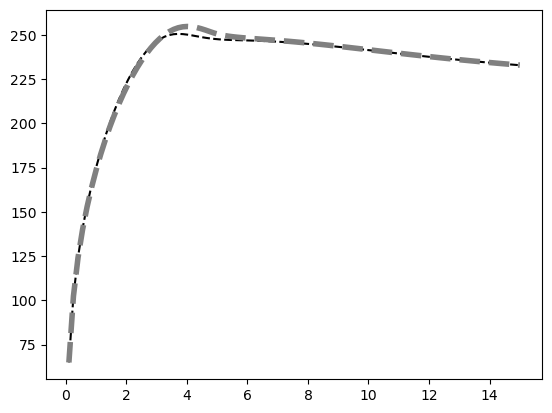

In [33]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*omega,ls="--",color="grey",lw=4)

## Generate DF

In [34]:
paxisym = agama.Potential(pbase,pot_pertuber_m0_static)

In [35]:
df = agama.DistributionFunction(type="QuasiIsothermal", Sigma0 = 1., Rdisk = 2.5, Hdisk = 0.3, 
                                Rsigmar = 5., sigmar0 = 35./np.exp(-8./5.), potential = paxisym)

## Run BI

In [36]:
pattern_speed = 35

In [37]:
force = paxisym.force(points_line)
omega = np.sqrt(-force[:,0]/r_)

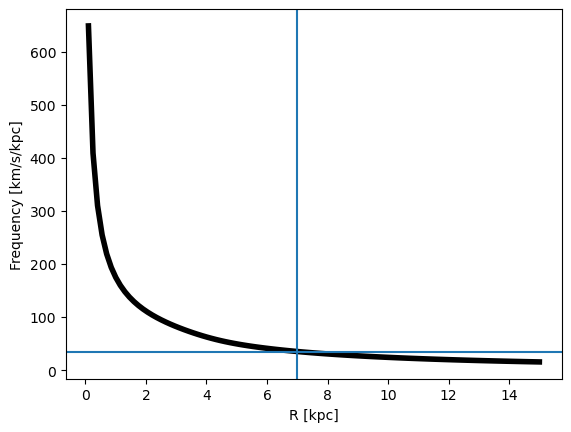

In [40]:
plt.plot(r_,omega,color="k",lw=4)
plt.axhline(pattern_speed)
plt.axvline(7)
plt.xlabel("R [kpc]")
plt.ylabel("Frequency [km/s/kpc]");

In [41]:
Tb = np.abs(2*np.pi/pattern_speed)
print(Tb)

0.17951958020513104


In [42]:
10*Tb

1.7951958020513104

In [43]:
def df_eval_func_test(points):
    af = agama.ActionFinder(paxisym)

    #compute actions at t=0
    actions = af(points)
    
    return df(actions)

In [45]:
df_eval,time,orbits = bibimbpy.orbits.runBI(ic,p_timedep,df_eval_func_test,10*Tb,10*Tb,pattern_speed)

2138 orbits complete (152.7 orbits/s)


In [47]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(axis[0],axis[1],df_eval,100)

In [48]:
df_sum.shape

(100, 100)

In [49]:
vre.shape

(101,)

In [50]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

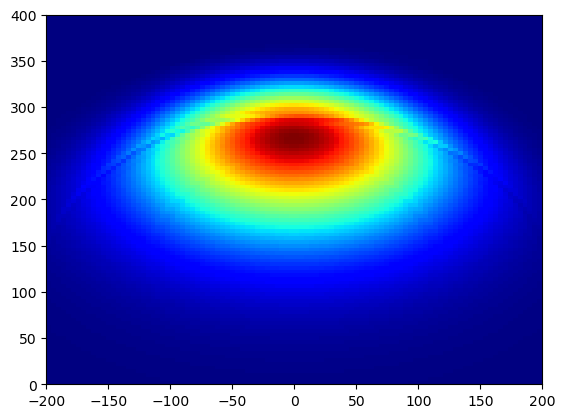

In [51]:
plt.pcolormesh(VR,VPHI,df_sum.T,cmap="jet")

# Reproduce Dehnen2000

In [52]:
def dehnen_base_pot(R,R0,beta,v0):
    """
    Requires setting up Agama units to 
    agama.setUnits(mass=1, length=R0, velocity=1)
    """
    if beta==0:
        return v0**2*np.log(R/R0)
    else:
        return v0**2/(2*beta)*(R/R0)**(2*beta)

In [53]:
def dehnen_bar_pot(R,phi,Rb,Ab):
    mask_in = R<Rb
    mask_out= R>=Rb
    
    pot = Ab*np.cos(2*phi)*np.ones_like(R)
    
    pot[mask_in] = pot[mask_in]*((R[mask_in]/Rb)**3-2)
    pot[mask_out]= pot[mask_out]*(-(Rb/R[mask_out])**3)
    
    return pot

def get_Ab(t,Af,t1):
    def aux_func(t,t1):
        return 2*t/t1-1
    
    aux = aux_func(t,t1)
    
    return Af*(3/16*aux**5-5/8*aux**3+15/16*aux+1/2)


def get_Af(alfa,v0,R0,Rb):
    return alfa*v0**2/3*(R0/Rb)**3

In [54]:
def get_Rc(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omegab/Omega0)**(1/(beta-1))

def get_Rolr(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omega0/Omegab*(1+np.sqrt((1+beta)/2)))**(1/(1-beta))

def get_omegabar(R0,Rolr,v0,beta):
    Omega0 = v0/R0
    return Omega0*(1+np.sqrt((1+beta)/2))/(Rolr/R0)**(1-beta)

In [55]:
def get_potential(R,params):
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    if beta==0:
        return v0**2*np.log(R/r0)
    else:
        return v0**2/(2*beta)*(R/r0)**(2*beta)

def get_actions(o,params):
    """
    Compute Lz and total Energy
    
    NOTE: Lz must be given in left handed coordinate system for consistency with Denhen DF
    (i.e., Lz will be returned positive for prograde orbits)
    """
    x  = o[:,0]
    y  = o[:,1]
    vx = o[:,3]
    vy = o[:,4]
    
    L = x*vy-y*vx
    E = 0.5*(vx**2+vy**2) + get_potential(np.sqrt(x**2+y**2),params)
    
    return L,E

def obtain_df(L,E,params):
    """
    $$f(E,L) = \frac{\gamma(R_E)\Sigma(R_E)}{2\pi\sigma_R^2(R_E)}exp[\frac{\Omega(R_E)(L-L_c(E))}{\sigma_R^2(R_E)}]$$
    """
    
    RE = get_RE(E,params)
    Lc = get_Lc(E,params)
    
    gamma = get_gamma(RE,params)
    Sigma = get_Sigma(RE,params)
    sigmaR= get_sigmaR(RE,params)
    omega = get_omega(RE,params)
    
    return (gamma*Sigma)/(2*np.pi*sigmaR**2)*np.exp(omega*(L-Lc)/sigmaR**2)

def get_RE(E,params):
    """
    $R_E = R_c(E) = R_0\times\begin{cases}
    [\frac{2\beta E}{v_0^2(1+\beta)}]^{1/(2\beta)} & \text{if } \beta\neq0 \\
    exp(\frac{E}{v_0^2}-\frac{1}{2}) & \text{if } \beta = 0
\end{cases}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    if beta==0:
        return r0*np.exp(E/v0**2-1/2)
    else:
        return r0*((2*beta*E)/(v0**2*(1+beta)))**(1/(2*beta))
    
def get_Lc(E,params):
    """
    $L_c(E) = v_0R_0\times\begin{cases}
    [\frac{2\beta E}{v_0^2(1+\beta)}]^{(1+\beta)/(2\beta)} & \text{if } \beta\neq0 \\
    exp(\frac{E}{v_0^2}-\frac{1}{2}) & \text{if } \beta = 0
\end{cases}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    if beta==0:
        return v0*r0*np.exp(E/v0**2-1/2)
    else:
        return v0*r0*((2*beta*E)/(v0**2*(1+beta)))**((1+beta)/(2*beta))
    
def get_omega(R,params):
    """
    $\Omega(R) = \frac{v_0}{R_0^\beta}R^{\beta-1}$
    """
    r0 = params["r0"]
    v0 = params["v0"]
    beta = params["beta"]
    
    return v0/r0**(beta)*R**(beta-1)

def get_gamma(R,params):
    """
    $\gamma = \sqrt{\frac{2}{1+\beta}}$
    """
    return np.sqrt(2/(1+params["beta"]))

def get_Sigma(R,params):
    """
    $\Sigma(R) = \Sigma_0exp(-R/R_s)$
    """
    return params["sigma0"]*np.exp(-R/params["rs"])

def get_sigmaR(R,params):
    """
    $\sigma_R(R) = \sigma_0exp(-R/R_\sigma)$
    """
    return params["sigmaR0"]*np.exp(-R/params["rsigma"])

In [56]:
def df_eval_func_dehnen(points):
    actions = get_actions(points,params)
    L,E = actions
    return obtain_df(L,E,params)

In [57]:
r_ic = 8
phi_ic = -30
z_ic = 0
vz_ic = 0
vrmax,vrmin = 200,-200
vphimax,vphimin = 400,0

vr_ic = np.linspace(vrmin,vrmax,200)
vphi_ic = np.linspace(vphimin,vphimax,200)

In [59]:
ic,(var1,var2) = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [60]:
ic.shape

(40000, 6)

In [61]:
## free parameters
R0 = 8
v0 = 240

In [62]:
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)

print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [63]:
Rb

3.3741298807309725

In [64]:
params = {"pattern_speed":Omegab,
"r0": R0,
"v0": v0,
"beta": beta,
"sigma0": 1,
"rs": 2.64,
"sigmaR0": 48,
"rsigma": 8}

In [65]:
pbase_params = {"type":"Multipole",
                "potential":lambda x: dehnen_base_pot(np.sqrt(x[:,0]**2+x[:,1]**2),R0,beta,v0),
               "gridSizeR":40, "Rmin":0.2, "Rmax":40, "lmax":4}

In [66]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",1000,"dehnen00_scaling.txt")

In [67]:
pbar_params = {"type":"CylSpline","symmetry":"Bisymmetric",
               "potential":lambda x: dehnen_bar_pot(np.sqrt(x[:,0]**2+x[:,1]**2),
                                                          np.arctan2(x[:,1],x[:,0]),
                                                          Rb,Af),
               "gridSizeR":40, "Rmin":0.2, "Rmax":40, "lmax":4,
              "scale":"dehnen00_scaling.txt"}

In [68]:
scaling = pandas.read_csv("dehnen00_scaling.txt",sep=" ")

In [69]:
scaling

,#Time,mass_scale,radius_scale
0,0.000000,0.000000e+00,1
1,0.000221,1.001501e-08,1
2,0.000442,7.999971e-08,1
3,0.000663,2.695932e-07,1
4,0.000884,6.380746e-07,1
...,...,...,...
995,0.219952,9.999994e-01,1
996,0.220173,9.999997e-01,1
997,0.220394,9.999999e-01,1
998,0.220615,1.000000e+00,1


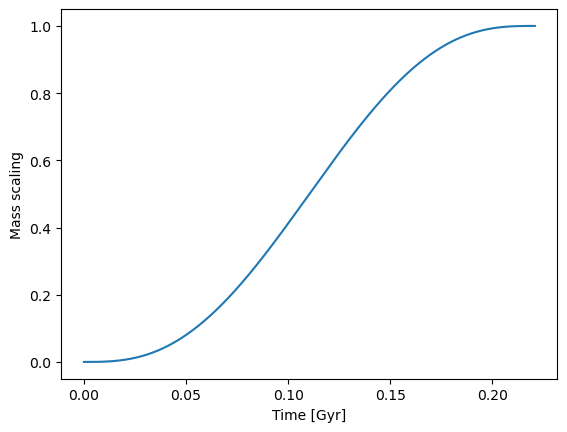

In [71]:
plt.plot(scaling["#Time"],scaling["mass_scale"])
plt.xlabel("Time [Gyr]")
plt.ylabel("Mass scaling");

In [72]:
perturb_pot,m0_static_pot = bibimbpy.initialize.generate_TimeDepPot(0.5,20,**pbar_params)

In [73]:
base_pot,timedep_pot = bibimbpy.initialize.generate_Pot(pbase_params,pbar_params,_rmin=0.5)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/2519702132.py:7: RuntimeWarning: divide by zero encountered in log
  return v0**2*np.log(R/R0)


In [74]:
pbar = agama.Potential(**pbar_params)

In [75]:
pbar.export("test_pbar_pot.ini")

In [76]:
pbg = agama.Potential(**pbase_params)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/2519702132.py:7: RuntimeWarning: divide by zero encountered in log
  return v0**2*np.log(R/R0)


In [77]:
timedep_pot2 = agama.Potential(pbg,pbar)

In [78]:
r_ = np.linspace(0,15,100)
phi_ = np.linspace(0,2*np.pi,100)

R,PHI = np.meshgrid(r_,phi_)

r = R.flatten()
phi = PHI.flatten()

z = np.zeros_like(r)
points = np.column_stack((r*np.cos(phi),r*np.sin(phi),z))

In [79]:
points_line = np.column_stack((r_,r_*0,r_*0))

In [80]:
force_bg = pbg.force(points_line)
omega_bg = np.sqrt(-force_bg[:,0]/r_)

bg_pot_eval = pbg.potential(points,t=t)

In [81]:
t = 0.3
Ab_ = 1591.0

In [82]:
force_bar = pbar.force(points_line,t=t)
omega_bar = np.sqrt(-force_bar[:,0]/r_)

bar_pot_eval = pbar.potential(points,t=t)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/1780834796.py:2: RuntimeWarning: invalid value encountered in divide
  omega_bar = np.sqrt(-force_bar[:,0]/r_)


In [83]:
force = timedep_pot.force(points_line,t=t)
omega = np.sqrt(-force[:,0]/r_)

timedep_pot_eval = timedep_pot.potential(points,t=t)

In [84]:
force2 = timedep_pot2.force(points_line,t=t)
omega2 = np.sqrt(-force2[:,0]/r_)

timedep_pot_eval2 = timedep_pot2.potential(points,t=t)

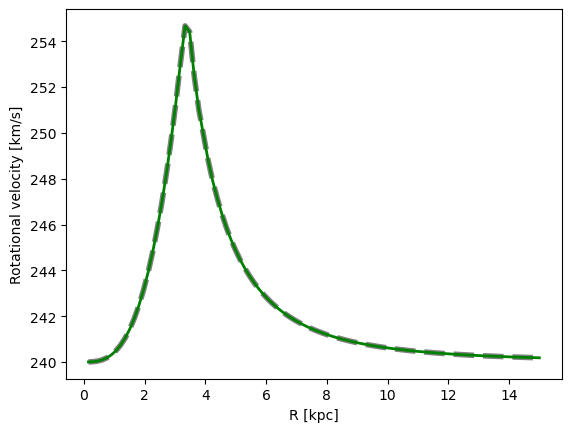

In [87]:
#plt.plot(r_,r_*omega_bg,ls="--",color="k")
plt.plot(r_,r_*omega,ls="--",color="grey",lw=4)
plt.plot(r_,r_*omega2,ls="-",color="g",lw=2)
#plt.plot(r_,r_*omega_bar,ls="-",color="r",lw=4)
plt.xlabel("R [kpc]")
plt.ylabel("Rotational velocity [km/s]");

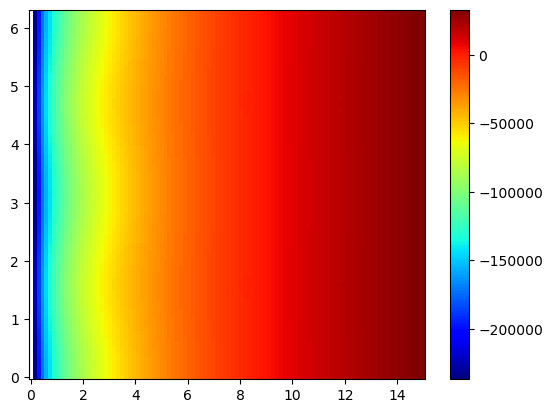

In [88]:
plt.pcolormesh(R,PHI,timedep_pot_eval2.reshape(R.shape),cmap="jet")
plt.colorbar();

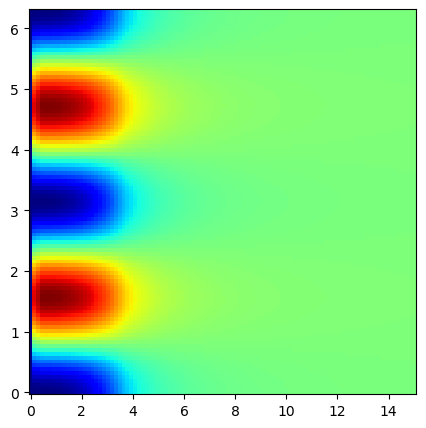

In [89]:
fig,ax1 = plt.subplots(figsize=(5,5),ncols=1)
ax1.pcolormesh(R,PHI,bar_pot_eval.reshape(R.shape),cmap="jet",vmin=np.min(bar_pot_eval),vmax=np.max(bar_pot_eval))

In [90]:
df_eval,time,orbits = bibimbpy.orbits.runBI(ic,timedep_pot,df_eval_func_dehnen,t2,t2,Omegab,_Npoints=1000)

40000 orbits complete (769.2 orbits/s)


In [91]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,bins=(vr_ic,vphi_ic))

In [92]:
df_sum.shape

(199, 199)

In [93]:
vre.shape

(200,)

In [94]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/4025990697.py:3: RuntimeWarning: divide by zero encountered in log10
  cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);


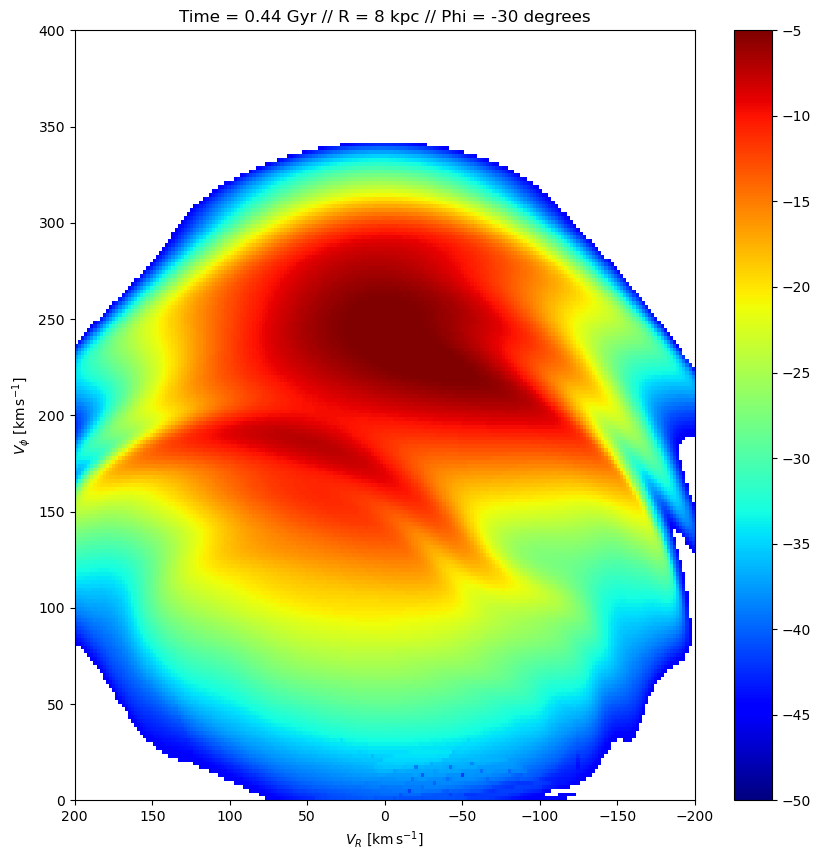

In [96]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);
plt.colorbar(cc)

ax.set_xlim(vrmax,vrmin)
if vphimin<0:
    ax.set_ylim(vphimax,vphimin)
else:
    ax.set_ylim(vphimin,vphimax)
ax.set_xlabel(r"$V_R$ [km$\,$s$^{-1}$]")
ax.set_ylabel(r"$V_\phi$ [km$\,$s$^{-1}$]")
ax.set_title(f"Time = {round(t2,2)} Gyr // R = {r_ic} kpc // Phi = {phi_ic} degrees");

fig.savefig("Dehnen2000_basic.png");

## Example of one orbit

In [98]:
j=520

In [101]:
o_inertial = bibimbpy.utils.rotating2inertial(time,orbits[j],Omegab)

(-12.0, 12.0)

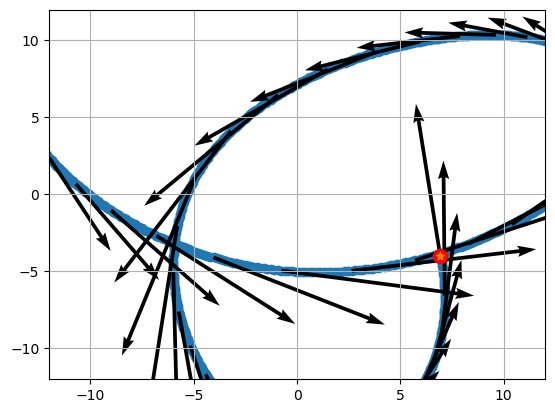

In [102]:
i=999
plt.scatter(o_inertial[:i,0],o_inertial[:i,1])
plt.quiver(o_inertial[:i:20,0],o_inertial[:i:20,1],o_inertial[:i:20,3],o_inertial[:i:20,4],scale=1000)
plt.scatter(o_inertial[0,0],o_inertial[0,1],c="r",s=100)
plt.scatter(o_inertial[i,0],o_inertial[i,1],c="g",s=100)
plt.scatter(r_ic*np.cos(np.deg2rad(phi_ic)),r_ic*np.sin(np.deg2rad(phi_ic)),marker="*")
plt.grid()
plt.xlim(-12,12)
plt.ylim(-12,12)

(-12.0, 12.0)

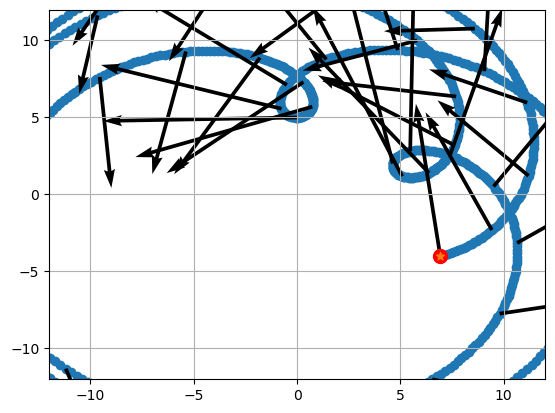

In [103]:
i=999
plt.scatter(orbits[j][:i,0],orbits[j][:i,1])
plt.quiver(orbits[j][:i:20,0],orbits[j][:i:20,1],orbits[j][:i:20,3],orbits[j][:i:20,4],scale=1000)
plt.scatter(orbits[j][0,0],orbits[j][0,1],c="r",s=100)
plt.scatter(orbits[j][i,0],orbits[j][i,1],c="g",s=100)
plt.scatter(r_ic*np.cos(np.deg2rad(phi_ic)),r_ic*np.sin(np.deg2rad(phi_ic)),marker="*")
plt.grid()
plt.xlim(-12,12)
plt.ylim(-12,12)

# Like Dehnen2000 but McMillan17 potential

In [104]:
r_ic = 8
phi_ic = -30
z_ic = 0
vz_ic = 0
vrmax,vrmin = 200,-200
vphimax,vphimin = 400,0

vr_ic = np.linspace(vrmin,vrmax,200)
vphi_ic = np.linspace(vphimin,vphimax,200)

In [105]:
ic,(var1,var2) = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [108]:
## free parameters
R0 = 8
v0 = 240

In [109]:
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)

print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [106]:
pbase_params = {"file":"McMillan17.ini"}

In [110]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",1000,"dehnen00_scaling.txt")

In [111]:
pbar_params = {"type":"CylSpline","symmetry":"Bisymmetric",
               "potential":lambda x: dehnen_bar_pot(np.sqrt(x[:,0]**2+x[:,1]**2),
                                                          np.arctan2(x[:,1],x[:,0]),
                                                          Rb,Af),
               "gridSizeR":40, "Rmin":0.2, "Rmax":40, "lmax":4,
              "scale":"dehnen00_scaling.txt"}

In [112]:
base_pot,timedep_pot = bibimbpy.initialize.generate_Pot(pbase_params,pbar_params,_rmin=0.5)

In [113]:
df_eval,time,orbits = bibimbpy.orbits.runBI(ic,timedep_pot,df_eval_func_dehnen,t2,t2,Omegab,_Npoints=1000)

40000 orbits complete (5714 orbits/s)


In [114]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,bins=(vr_ic,vphi_ic))

In [115]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/4227909651.py:3: RuntimeWarning: divide by zero encountered in log10
  cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);


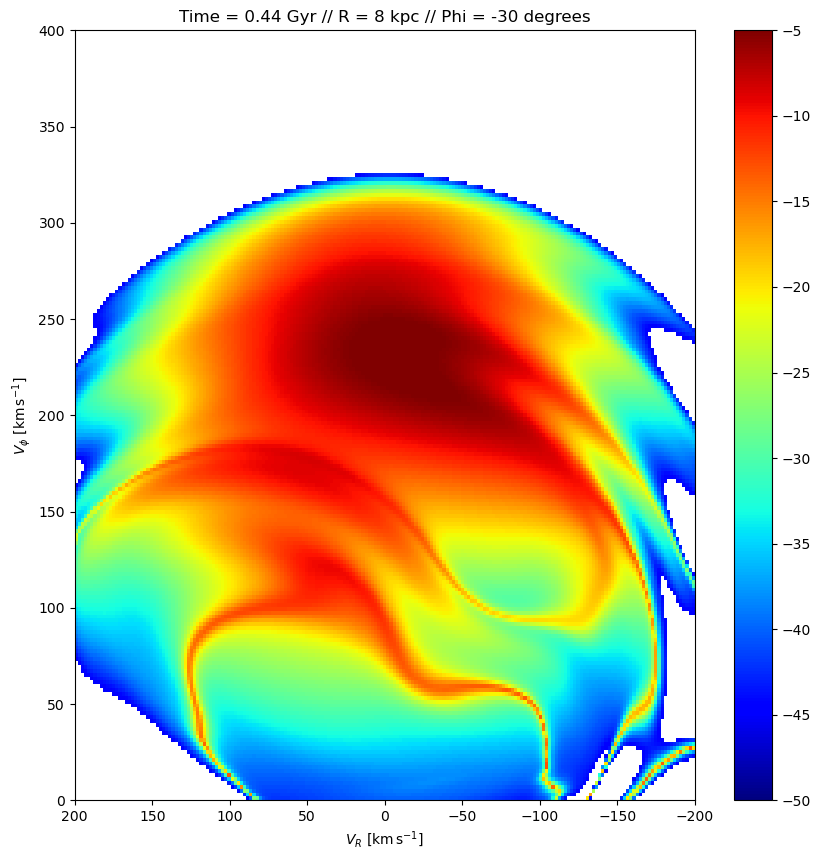

In [116]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);
plt.colorbar(cc)

ax.set_xlim(vrmax,vrmin)
if vphimin<0:
    ax.set_ylim(vphimax,vphimin)
else:
    ax.set_ylim(vphimin,vphimax)
ax.set_xlabel(r"$V_R$ [km$\,$s$^{-1}$]")
ax.set_ylabel(r"$V_\phi$ [km$\,$s$^{-1}$]")
ax.set_title(f"Time = {round(t2,2)} Gyr // R = {r_ic} kpc // Phi = {phi_ic} degrees");

fig.savefig("Dehnen2000_McMillan17.png");

# Like Dehnen2000 but McMillan17 potential and Ferrer bar

In [117]:
r_ic = 8
phi_ic = -30
z_ic = 0
vz_ic = 0
vrmax,vrmin = 200,-200
vphimax,vphimin = 400,0

vr_ic = np.linspace(vrmin,vrmax,200)
vphi_ic = np.linspace(vphimin,vphimax,200)

In [119]:
ic,(var1,var2) = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [120]:
## free parameters
R0 = 8
v0 = 240

In [121]:
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)

print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [126]:
pbase_params = {"file":"McMillan17.ini"}

In [127]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",1000,"dehnen00_scaling.txt")

In [128]:
pbar_params = {"type":"Ferrers","mass":2e10,"scaleRadius":3.37,"axisRatioY":0.5,"axisRatioZ":0.1,
              "scale":"dehnen00_scaling.txt"}

In [129]:
base_pot,timedep_pot = bibimbpy.initialize.generate_Pot(pbase_params,pbar_params,_rmin=0.5)

In [130]:
%%time
df_eval,time,orbits = bibimbpy.orbits.runBI(ic,timedep_pot,df_eval_func_dehnen,t2,t2,Omegab,_Npoints=1000)

40000 orbits complete (6667 orbits/s)
CPU times: user 1min 19s, sys: 1.57 s, total: 1min 20s
Wall time: 9.31 s


In [131]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,bins=(vr_ic,vphi_ic))

In [132]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/212489537.py:3: RuntimeWarning: divide by zero encountered in log10
  cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);


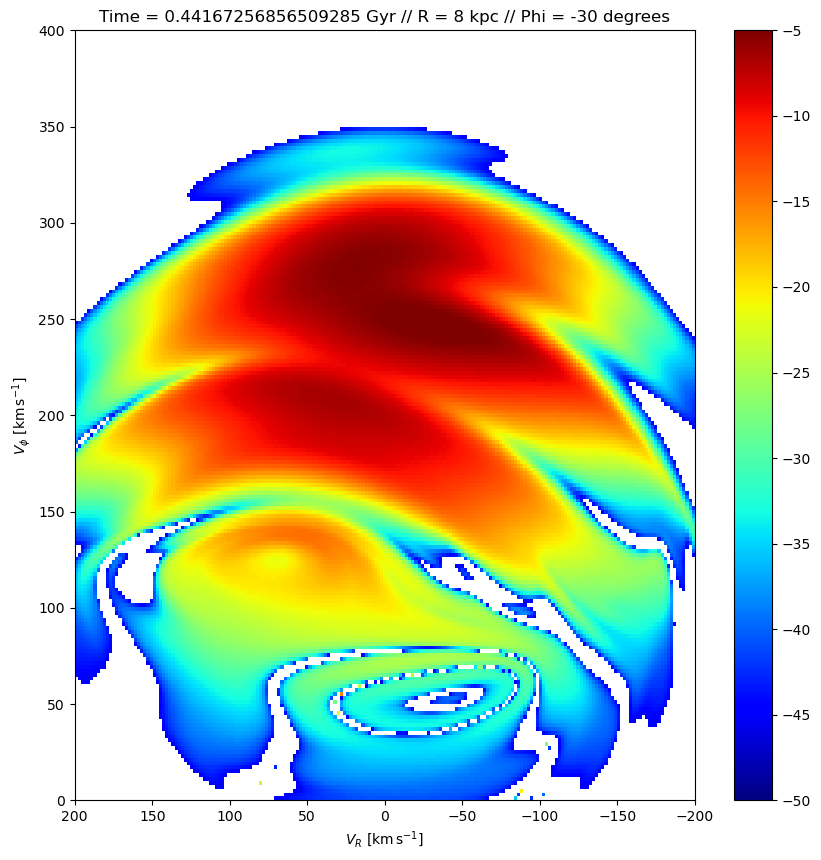

In [133]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);
plt.colorbar(cc)

ax.set_xlim(vrmax,vrmin)
if vphimin<0:
    ax.set_ylim(vphimax,vphimin)
else:
    ax.set_ylim(vphimin,vphimax)
ax.set_xlabel(r"$V_R$ [km$\,$s$^{-1}$]")
ax.set_ylabel(r"$V_\phi$ [km$\,$s$^{-1}$]")
ax.set_title(f"Time = {t2} Gyr // R = {r_ic} kpc // Phi = {phi_ic} degrees");

fig.savefig("Dehnen2000_McMillan17_Ferrers.png")

# Like Dehnen2000 but McMillan17 potential and Ferrer bar and Quasi-isothermal DF

In [136]:
r_ic = 8
phi_ic = -30
z_ic = 0
vz_ic = 0
vrmax,vrmin = 200,-200
vphimax,vphimin = 400,0

vr_ic = np.linspace(vrmin,vrmax,200)
vphi_ic = np.linspace(vphimin,vphimax,200)

In [114]:
ic,(var1,var2) = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [137]:
## free parameters
R0 = 8
v0 = 240

In [138]:
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)

print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [139]:
pbase_params = {"file":"McMillan17.ini"}

In [140]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",1000,"dehnen00_scaling.txt")

In [141]:
pbar_params = {"type":"Ferrers","mass":2e10,"scaleRadius":3.37,"axisRatioY":0.5,"axisRatioZ":0.1,
              "scale":"dehnen00_scaling.txt"}

In [142]:
base_pot,timedep_pot = bibimbpy.initialize.generate_Pot(pbase_params,pbar_params,_rmin=0.5)

In [143]:
df = agama.DistributionFunction(type="QuasiIsothermal", Sigma0 = 10., Rdisk = 2.64, Hdisk = 0.3, 
                                Rsigmar = 8., sigmar0 = 20./np.exp(-8./8.), potential = base_pot)

In [146]:
def df_eval_func(points):
    """
    Given an AGAMA potential and distribution function, return the values of the
    distribution function at the given points in real 6D space (positions and velocities)
    """
    #action-angle
    af = agama.ActionFinder(base_pot)

    #compute actions at t=0
    actions = af(points)

    return df(actions)

In [147]:
%%time
df_eval,time,orbits = bibimbpy.orbits.runBI(ic,timedep_pot,df_eval_func,t2,t2,Omegab,_Npoints=1000)

40000 orbits complete (4444 orbits/s)
CPU times: user 1min 23s, sys: 2.19 s, total: 1min 25s
Wall time: 9.58 s


In [148]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,bins=(vr_ic,vphi_ic))

In [149]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_8428/2361930860.py:3: RuntimeWarning: divide by zero encountered in log10
  cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);


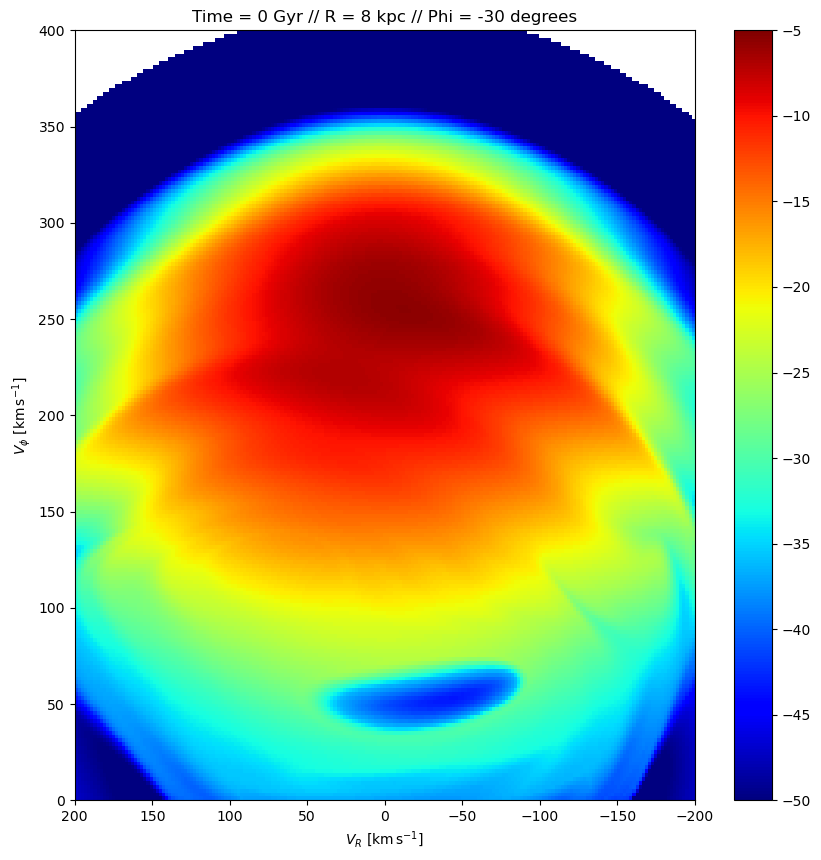

In [150]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cc = ax.pcolormesh(VR,VPHI,np.log10(df_sum.T),cmap="jet",vmin=-50,vmax=-5);
plt.colorbar(cc)

ax.set_xlim(vrmax,vrmin)
if vphimin<0:
    ax.set_ylim(vphimax,vphimin)
else:
    ax.set_ylim(vphimin,vphimax)
ax.set_xlabel(r"$V_R$ [km$\,$s$^{-1}$]")
ax.set_ylabel(r"$V_\phi$ [km$\,$s$^{-1}$]")
ax.set_title(f"Time = {round(t2)} Gyr // R = {r_ic} kpc // Phi = {phi_ic} degrees");

fig.savefig("Dehnen2000_McMillan17_Ferrers_QIdf.png");

In [151]:
particle_fin_barframe = np.stack([o[-1] for o in orbits])

In [152]:
af = agama.ActionFinder(base_pot)

In [153]:
#compute actions at t=0
actions = af(particle_fin_barframe)

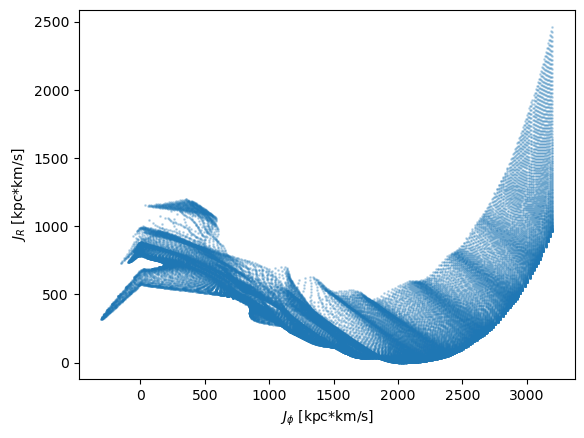

In [154]:
plt.scatter(actions[:,2],actions[:,0],alpha=0.25,s=1)
plt.xlabel(r"$J_\phi$ [kpc*km/s]")
plt.ylabel(r"$J_R$ [kpc*km/s]");